In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import numpy as np

mlp_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

root_dir = 'q2_data'

mlp_dataset = ImageFolder(root=root_dir , transform=mlp_transform)

class_indices = {i: [] for i in range(10)}
for index, (_, label) in enumerate(mlp_dataset.samples):
    class_indices[label].append(index)

train_indices = []
val_indices = []

for label, indices in class_indices.items():
    np.random.shuffle(indices)
    split = int(0.8 * len(indices))
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_dataset = Subset(mlp_dataset, train_indices)
val_dataset = Subset(mlp_dataset, val_indices)

batch_size = 32
train_mlp_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_mlp_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

train_images, train_labels = next(iter(train_mlp_dataloader))
print(train_images.shape, train_labels.shape)

Training dataset size: 8000
Validation dataset size: 2000
torch.Size([32, 784]) torch.Size([32])


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.output(x)  # No softmax (CrossEntropyLoss handles it)
        return x

mlp = MLP()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10


# Training loop
for epoch in range(num_epochs):
    total_batch_loss = 0
    for images, labels in train_mlp_dataloader:
        optimizer.zero_grad()  # Clear gradients

        outputs = mlp(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_batch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_batch_loss/len(train_mlp_dataloader):.4f}")

print("Training complete!")
print(len(train_mlp_dataloader))

Epoch 1/10, Loss: 2.3015
Epoch 2/10, Loss: 2.0803
Epoch 3/10, Loss: 0.9805
Epoch 4/10, Loss: 0.4887
Epoch 5/10, Loss: 0.2878
Epoch 6/10, Loss: 0.1976
Epoch 7/10, Loss: 0.1358
Epoch 8/10, Loss: 0.1055
Epoch 9/10, Loss: 0.0861
Epoch 10/10, Loss: 0.0723
Training complete!
250


In [4]:
import torch
from torch.utils.data import DataLoader

mlp.eval()  # Set model to evaluation mode

image, label = next(iter(val_mlp_dataloader))
first_image = image[0].unsqueeze(0)  # Get first image from batch and add batch dimension

with torch.no_grad():
    output = mlp(first_image)
    probabilities = torch.softmax(output, dim=1)

print("Model output probabilities:", probabilities)
print("Predicted class:", torch.argmax(probabilities).item())
print("True class:", label[0].item())

Model output probabilities: tensor([[9.9994e-01, 1.4697e-18, 5.9839e-08, 4.8881e-10, 2.1533e-12, 6.4153e-05,
         2.7061e-07, 3.0398e-08, 3.9207e-08, 9.0250e-09]])
Predicted class: 0
True class: 0


In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

# Define Transformations for CNN
cnn_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

root_dir = 'q2_data'
cnn_dataset = ImageFolder(root=root_dir, transform=cnn_transform)

class_indices = {i: [] for i in range(10)}
for index, (_, label) in enumerate(cnn_dataset.samples):
    class_indices[label].append(index)
    
train_indices = []
val_indices = []

for label, indices in class_indices.items():
    np.random.shuffle(indices)
    split = int(0.8 * len(indices))
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_dataset = Subset(cnn_dataset, train_indices)
val_dataset = Subset(cnn_dataset, val_indices)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

batch_size = 32
train_cnn_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_cnn_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_cnn_dataloader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Training dataset size: 8000
Validation dataset size: 2000
Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=64) 
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x) 
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    

cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    total_batch_loss = 0
    for images, labels in train_cnn_dataloader:
        optimizer.zero_grad() # Clear gradients
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_batch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_batch_loss/len(train_cnn_dataloader):.4f}")

print(len(train_cnn_dataloader))

print("Training complete!")

    

Epoch 1/10, Loss: 1.1651
Epoch 2/10, Loss: 0.4053
Epoch 3/10, Loss: 0.2911
Epoch 4/10, Loss: 0.2346
Epoch 5/10, Loss: 0.1949
Epoch 6/10, Loss: 0.1728
Epoch 7/10, Loss: 0.1569
Epoch 8/10, Loss: 0.1469
Epoch 9/10, Loss: 0.1262
Epoch 10/10, Loss: 0.1188
250
Training complete!


In [7]:
cnn.eval()

image, label = next(iter(val_cnn_dataloader))
first_image = image[0].unsqueeze(0)  # Get first image from batch and add batch dimension

with torch.no_grad():
    output = cnn(first_image)
    probabilities = torch.softmax(output, dim=1)

print("Model output probabilities:", probabilities)
print("Predicted class:", torch.argmax(probabilities).item())
print("True class:", label[0].item())


Model output probabilities: tensor([[1.0000e+00, 2.7515e-13, 3.7845e-08, 3.1797e-10, 9.4998e-16, 4.1046e-08,
         3.4273e-08, 4.9783e-08, 5.1891e-09, 4.9512e-07]])
Predicted class: 0
True class: 0


In [8]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

pca_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

root_dir = 'q2_data'
pca_dataset = datasets.ImageFolder(root=root_dir, transform=pca_transform)

class_indices = {i: [] for i in range(10)}
for index, (_, label) in enumerate(pca_dataset.samples):
    class_indices[label].append(index)

train_indices = []
val_indices = []

for label, indices in class_indices.items():
    np.random.shuffle(indices)
    split = int(0.8 * len(indices))
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_dataset = Subset(pca_dataset, train_indices)
val_dataset = Subset(pca_dataset, val_indices)

print(len(train_dataset))

train_pca_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_pca_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

train_images, train_labels = next(iter(train_pca_loader))

train_images = train_images.numpy()
print("Train images shape:", train_images.shape)

train_images_mean = np.mean(train_images, axis=0)
train_images_std = np.std(train_images, axis=0) + 1e-6
train_images_standardized = (train_images - train_images_mean) / train_images_std

# Compute Covariance Matrix
cov_matrix = np.cov(train_images_standardized, rowvar=False)

# Compute Eigenvalues and Eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort Eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]

# Reduce dimensions
k = 128
eigenvectors_k = eigenvectors[:, :k]

train_data_pca = np.dot(train_images_standardized, eigenvectors_k)

val_images, val_labels = next(iter(val_pca_loader))
val_images = val_images.numpy()
val_images_standardized = (val_images - train_images_mean) / train_images_std

val_data_pca = np.dot(val_images_standardized, eigenvectors_k)

print("PCA Train Data Shape:", train_data_pca.shape)
print("PCA Validation Data Shape:", val_data_pca.shape)

print(f'Train Labels: {train_labels.shape}')




8000
Train images shape: (8000, 784)
PCA Train Data Shape: (8000, 128)
PCA Validation Data Shape: (2000, 128)
Train Labels: torch.Size([8000])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

mlp_pca = MLP(input_dim=k)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mlp_pca.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10

train_data_pca_tensor = torch.tensor(train_data_pca, dtype=torch.float32)
train_labels_tensor = train_labels.clone().detach().long()


print(f"Train Data Shape: {train_data_pca_tensor.shape}")
print(f"Train Labels Shape: {train_labels_tensor.shape}")

train_pca_dataset = torch.utils.data.TensorDataset(train_data_pca_tensor, train_labels_tensor)
train_pca_loader = torch.utils.data.DataLoader(train_pca_dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    total_batch_loss = 0
    for features, labels in train_pca_loader:
        optimizer.zero_grad()
        outputs = mlp_pca(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_batch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_batch_loss/len(train_pca_loader):.4f}")

print(len(train_pca_loader))

print("Training complete!")




Train Data Shape: torch.Size([8000, 128])
Train Labels Shape: torch.Size([8000])
Epoch 1/10, Loss: 2.0493
Epoch 2/10, Loss: 0.5038
Epoch 3/10, Loss: 0.2506
Epoch 4/10, Loss: 0.1785
Epoch 5/10, Loss: 0.1441
Epoch 6/10, Loss: 0.1063
Epoch 7/10, Loss: 0.1080
Epoch 8/10, Loss: 0.0733
Epoch 9/10, Loss: 0.0670
Epoch 10/10, Loss: 0.0491
250
Training complete!


In [10]:
import torch
from torch.utils.data import DataLoader

mlp_pca.eval()

val_data_pca_tensor = torch.tensor(val_data_pca, dtype=torch.float32)
val_labels_tensor = val_labels.clone().detach().long()

val_pca_dataset = torch.utils.data.TensorDataset(val_data_pca_tensor, val_labels_tensor)
val_pca_loader = torch.utils.data.DataLoader(val_pca_dataset, batch_size=32, shuffle=False)

image, label = next(iter(val_pca_loader))
first_image = image[0].unsqueeze(0)  # Get first image from batch and add batch dimension

with torch.no_grad():
    output = mlp_pca(first_image)
    probabilities = torch.softmax(output, dim=1)

print("Model output probabilities:", probabilities)
print("Predicted class:", torch.argmax(probabilities).item())
print("True class:", label[0].item())


Model output probabilities: tensor([[9.9994e-01, 6.1806e-15, 8.8146e-06, 3.7397e-10, 4.0070e-06, 1.9551e-08,
         2.2772e-07, 8.6880e-06, 1.1171e-07, 4.2213e-05]])
Predicted class: 0
True class: 0


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class Logistic_MultiClass_Regression(nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super(Logistic_MultiClass_Regression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

logistic_regression = Logistic_MultiClass_Regression(input_dim = k)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(logistic_regression.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    total_batch_loss = 0
    for images, labels in train_pca_loader:
        optimizer.zero_grad() # Clear gradients
        
        outputs = logistic_regression(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_batch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_batch_loss/len(train_mlp_dataloader):.4f}")

print("Training complete!")

Epoch 1/10, Loss: 0.5415
Epoch 2/10, Loss: 0.3544
Epoch 3/10, Loss: 0.3350
Epoch 4/10, Loss: 0.3134
Epoch 5/10, Loss: 0.3141
Epoch 6/10, Loss: 0.3018
Epoch 7/10, Loss: 0.2990
Epoch 8/10, Loss: 0.2936
Epoch 9/10, Loss: 0.2870
Epoch 10/10, Loss: 0.2910
Training complete!


In [12]:
logistic_regression.eval()

image, label = next(iter(val_pca_loader))
first_image = image[0].unsqueeze(0)  # Get first image from batch and add batch dimension

with torch.no_grad():
    output = logistic_regression(first_image)
    probabilities = torch.softmax(output, dim=1)

print("Model output probabilities:", probabilities)
print("Predicted class:", torch.argmax(probabilities).item())
print("True class:", label[0].item())

Model output probabilities: tensor([[9.9945e-01, 2.1090e-10, 1.6209e-06, 1.6745e-05, 9.5925e-09, 3.1011e-05,
         3.3812e-10, 6.5761e-05, 1.0510e-05, 4.2130e-04]])
Predicted class: 0
True class: 0


In [13]:
# Reconstruct the image from PCA

# X_recons = (X_pca * W_k^T) * std + mean
reconstructed_images = np.dot(train_data_pca, eigenvectors_k.T) * train_images_std + train_images_mean

reconstructed_image = reconstructed_images[0].reshape(28, 28)
print("Reconstructed image shape:", reconstructed_image.shape)

Reconstructed image shape: (28, 28)


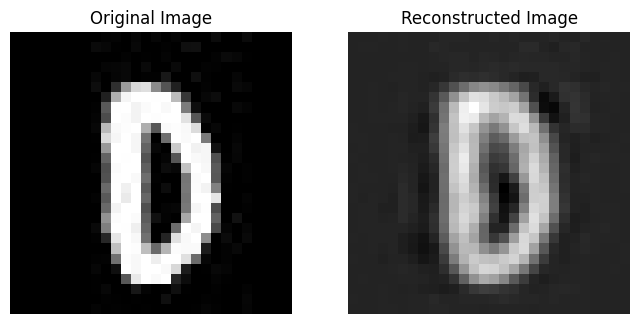

In [14]:
import matplotlib.pyplot as plt

original_image = train_images[0].reshape(28, 28)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim


class Logistic_Binary_Regression(nn.Module):
    def __init__(self, input_dim=784):
        super(Logistic_Binary_Regression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_one_vs_rest_classifiers(train_loader, num_classes = 10, input_dim = k, lr = 0.01, epochs = 10):
    classifiers = []
    
    for class_index in range(num_classes):
        print(f"Training classifier for class {class_index}")
        model = Logistic_Binary_Regression(input_dim)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            total_batch_loss = 0
            for features, labels in train_loader:
                labels_ovr = (labels == class_index).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels_ovr)
                loss.backward()
                optimizer.step()
                total_batch_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_batch_loss/len(train_loader):.4f}")
        
        classifiers.append(model)
    
    return classifiers

def predict_one_vs_rest_classifiers(classifiers, data_loader):
    predictions = []
    
    for features, _ in data_loader:
        batch_predictions = torch.cat([classifier(features) for classifier in classifiers], dim=1)
        predictions.append(batch_predictions)
    
    return torch.cat(predictions)

ovr_classifiers = train_one_vs_rest_classifiers(train_pca_loader, num_classes=10, input_dim=k, lr=0.01, epochs=10)

Training classifier for class 0
Epoch 1/10, Loss: 0.4624
Epoch 2/10, Loss: 0.2585
Epoch 3/10, Loss: 0.1882
Epoch 4/10, Loss: 0.1494
Epoch 5/10, Loss: 0.1256
Epoch 6/10, Loss: 0.1093
Epoch 7/10, Loss: 0.0977
Epoch 8/10, Loss: 0.0888
Epoch 9/10, Loss: 0.0820
Epoch 10/10, Loss: 0.0764
Training classifier for class 1
Epoch 1/10, Loss: 0.4760
Epoch 2/10, Loss: 0.2741
Epoch 3/10, Loss: 0.2016
Epoch 4/10, Loss: 0.1628
Epoch 5/10, Loss: 0.1388
Epoch 6/10, Loss: 0.1226
Epoch 7/10, Loss: 0.1107
Epoch 8/10, Loss: 0.1017
Epoch 9/10, Loss: 0.0947
Epoch 10/10, Loss: 0.0889
Training classifier for class 2
Epoch 1/10, Loss: 0.4888
Epoch 2/10, Loss: 0.2887
Epoch 3/10, Loss: 0.2167
Epoch 4/10, Loss: 0.1785
Epoch 5/10, Loss: 0.1559
Epoch 6/10, Loss: 0.1401
Epoch 7/10, Loss: 0.1289
Epoch 8/10, Loss: 0.1207
Epoch 9/10, Loss: 0.1140
Epoch 10/10, Loss: 0.1088
Training classifier for class 3
Epoch 1/10, Loss: 0.4715
Epoch 2/10, Loss: 0.2876
Epoch 3/10, Loss: 0.2211
Epoch 4/10, Loss: 0.1857
Epoch 5/10, Loss: 0

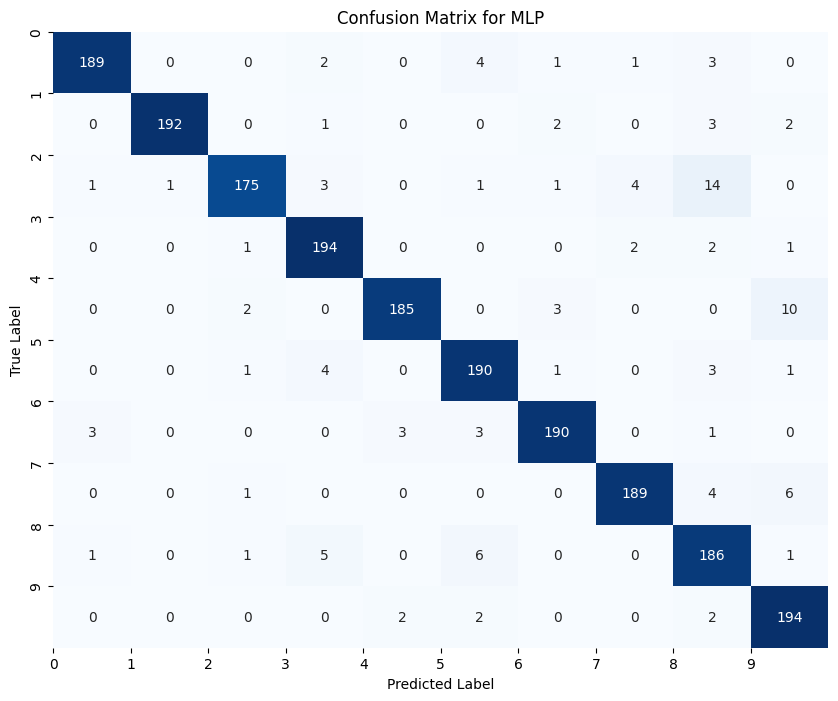

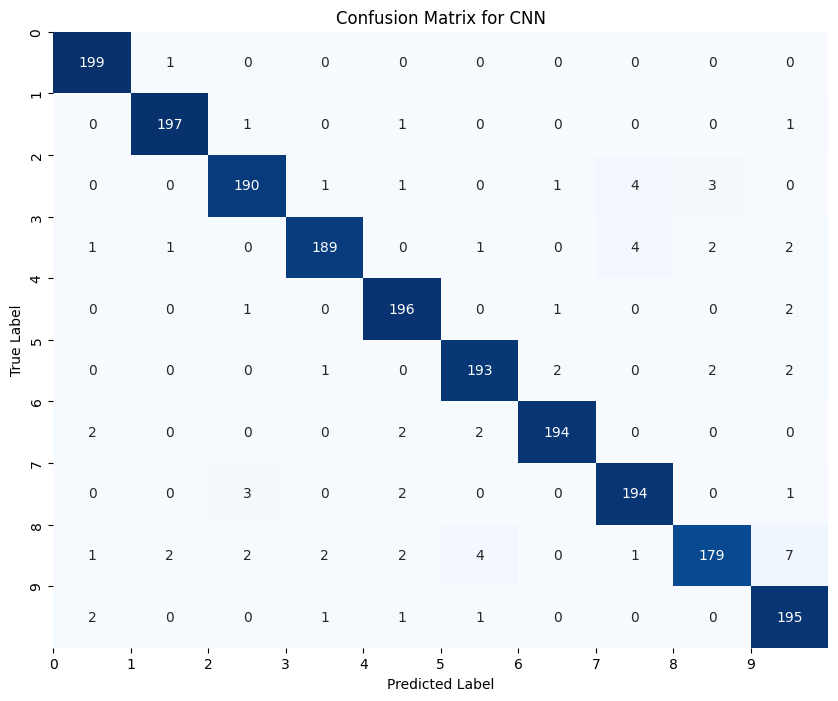

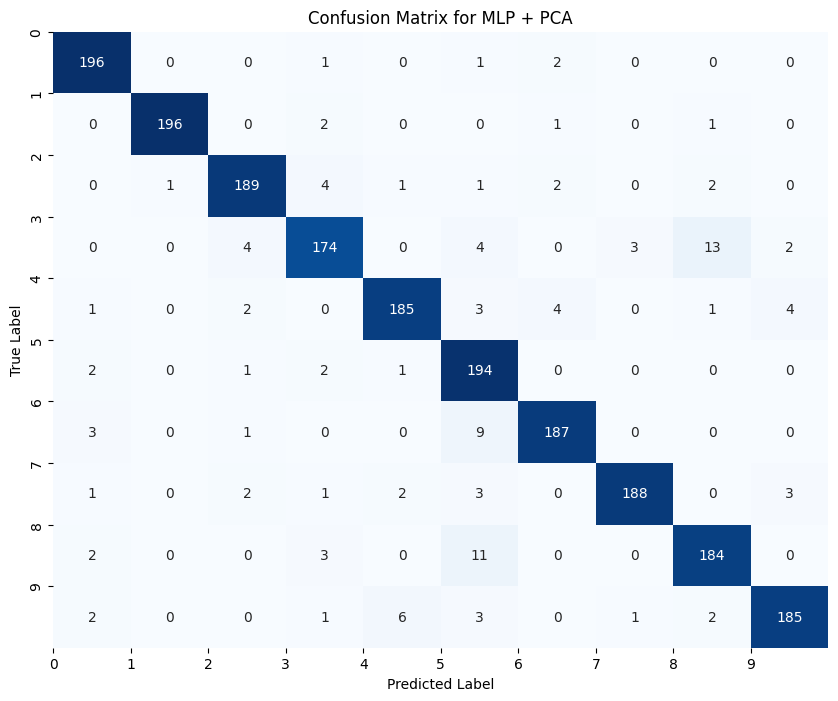

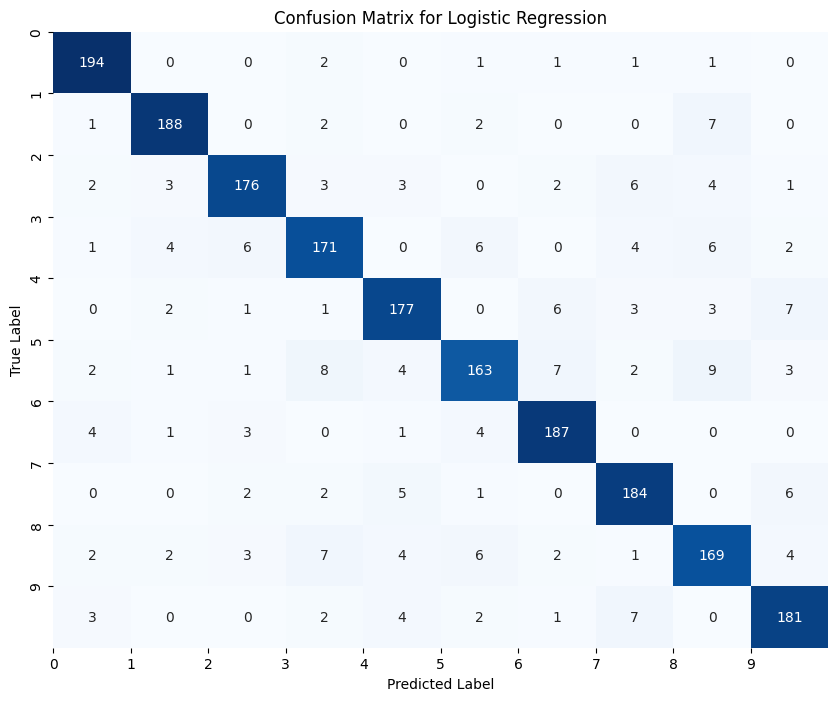

In [16]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, dataloader):
    model.eval()
    confusion_matrix = np.zeros((10, 10), dtype=int)
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            for i in range(len(labels)):
                confusion_matrix[labels[i].item(), predictions[i].item()] += 1
    
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=np.arange(10), labels=np.arange(10))
    plt.yticks(ticks=np.arange(10), labels=np.arange(10))
    plt.show()
    

def evaluate_performance_metrics(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1_score  # Per class

# Compute performance metrics for each model
models = {
    "MLP": (mlp, val_mlp_dataloader),
    "CNN": (cnn, val_cnn_dataloader),
    "MLP + PCA": (mlp_pca, val_pca_loader),
    "Logistic Regression": (logistic_regression, val_pca_loader),
}

class_results = {i: [] for i in range(10)}  # Store results for each class

for model_name, (model, dataloader) in models.items():
    conf_matrix = compute_confusion_matrix(model, dataloader)
    accuracy, precision, recall, f1_score = evaluate_performance_metrics(conf_matrix)
    plot_confusion_matrix(conf_matrix, model_name)

    for class_idx in range(10):
        class_results[class_idx].append([
            model_name, accuracy[class_idx], precision[class_idx], recall[class_idx], f1_score[class_idx]
        ])




In [17]:
# Print tables for each class
for class_idx in range(10):
    df_class = pd.DataFrame(class_results[class_idx], columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
    
    print("\n" + "="*50)
    print(f" Performance Metrics for Class {class_idx} ")
    print("="*50 + "\n")
    
    print(df_class.to_string(index=False))  # Print table without row index


 Performance Metrics for Class 0 

              Model  Accuracy  Precision  Recall  F1 Score
                MLP    0.9920   0.974227   0.945  0.959391
                CNN    0.9965   0.970732   0.995  0.982716
          MLP + PCA    0.9925   0.946860   0.980  0.963145
Logistic Regression    0.9895   0.928230   0.970  0.948655

 Performance Metrics for Class 1 

              Model  Accuracy  Precision  Recall  F1 Score
                MLP    0.9955   0.994819   0.960  0.977099
                CNN    0.9965   0.980100   0.985  0.982544
          MLP + PCA    0.9975   0.994924   0.980  0.987406
Logistic Regression    0.9875   0.935323   0.940  0.937656

 Performance Metrics for Class 2 

              Model  Accuracy  Precision  Recall  F1 Score
                MLP    0.9845   0.966851   0.875  0.918635
                CNN    0.9915   0.964467   0.950  0.957179
          MLP + PCA    0.9895   0.949749   0.945  0.947368
Logistic Regression    0.9800   0.916667   0.880  0.897959

 Perfo

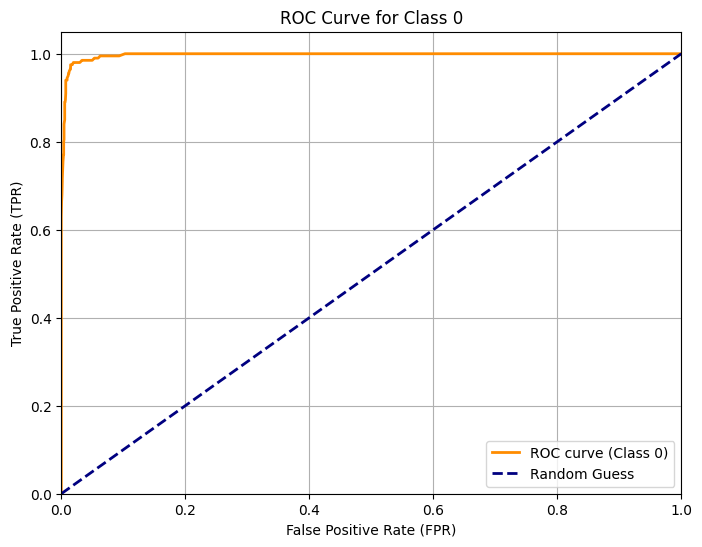

AUC for class 0: 0.9971


C:\Users\Ashwin K M\AppData\Local\Temp\ipykernel_14512\3431492098.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr_sorted, fpr_sorted)


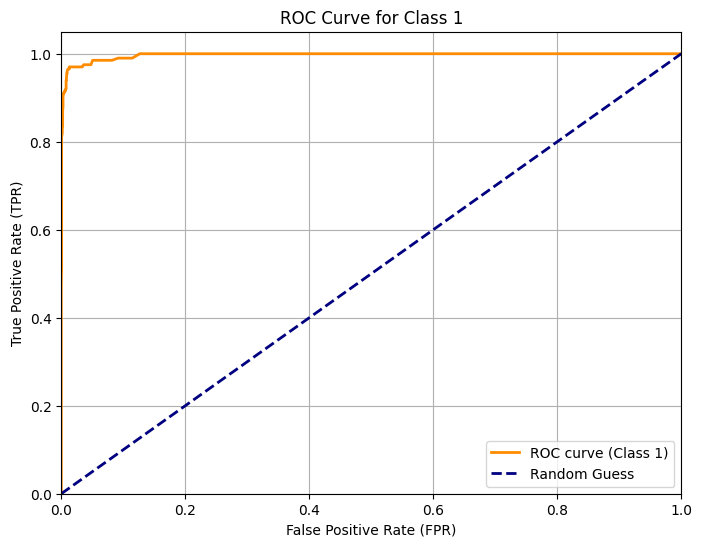

AUC for class 1: 0.9968


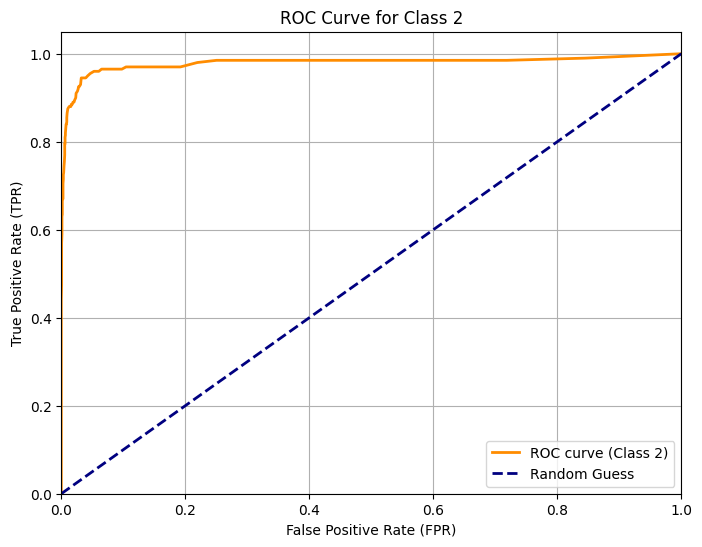

AUC for class 2: 0.9791


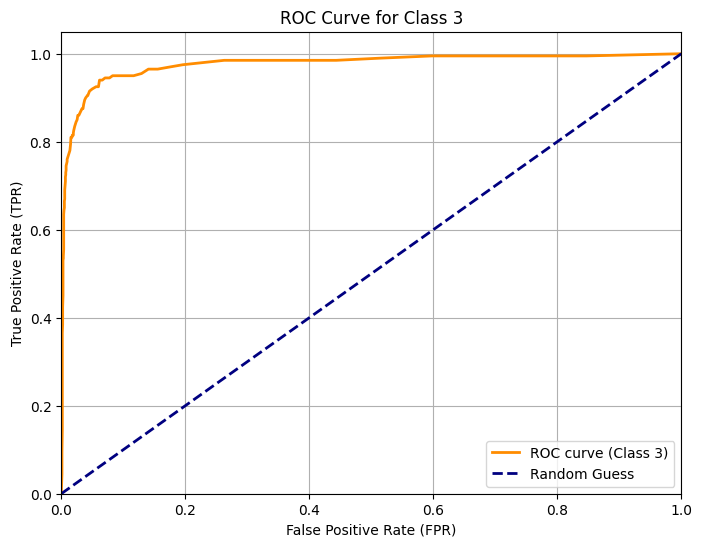

AUC for class 3: 0.9761


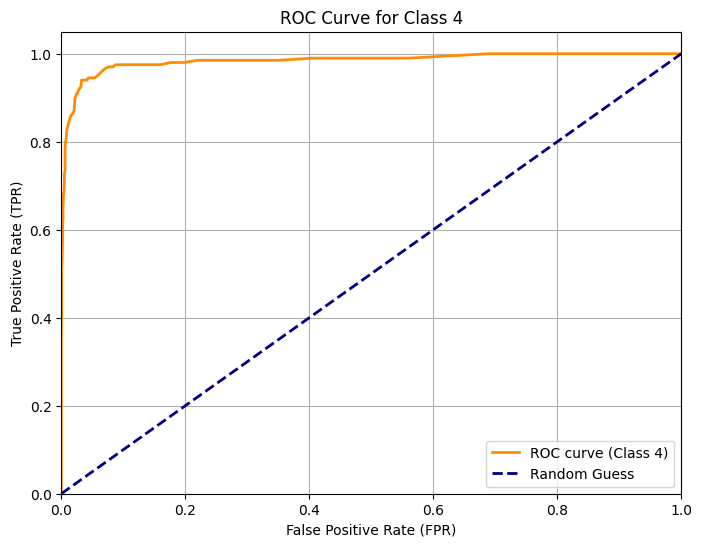

AUC for class 4: 0.9840


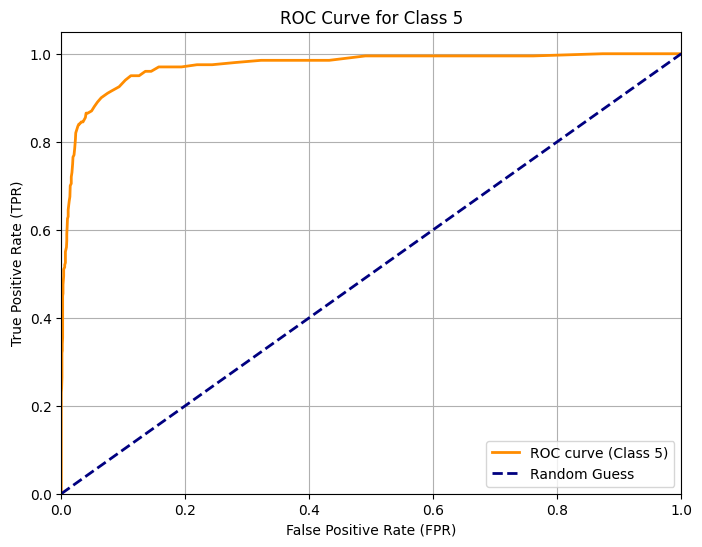

AUC for class 5: 0.9720


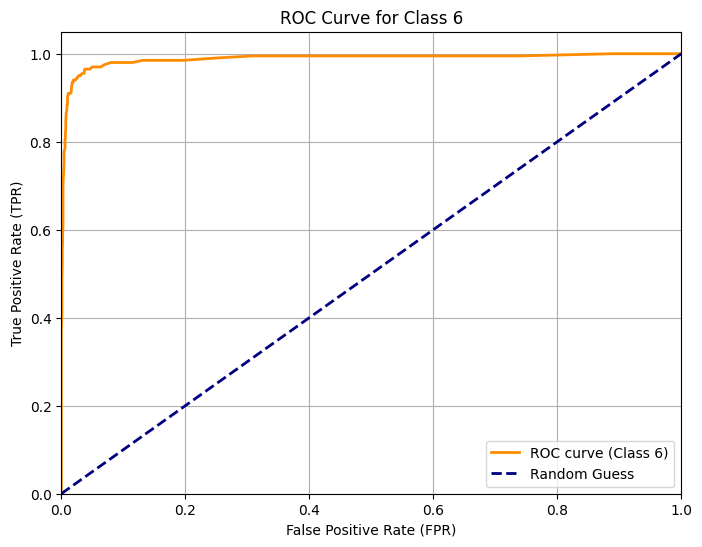

AUC for class 6: 0.9887


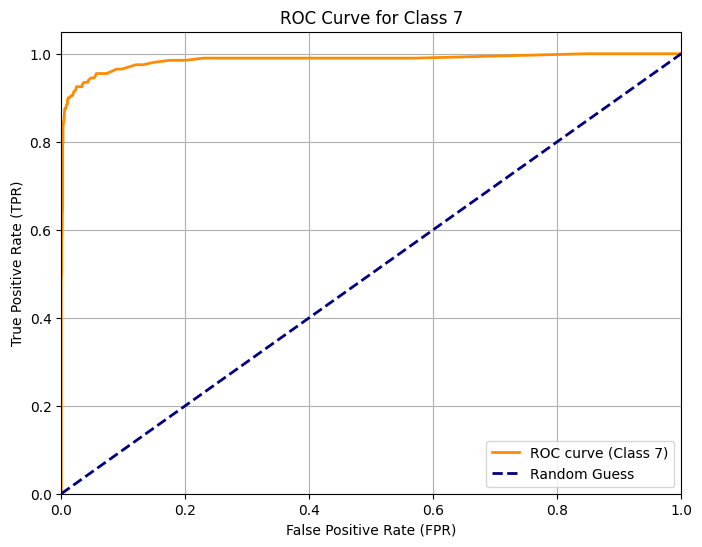

AUC for class 7: 0.9856


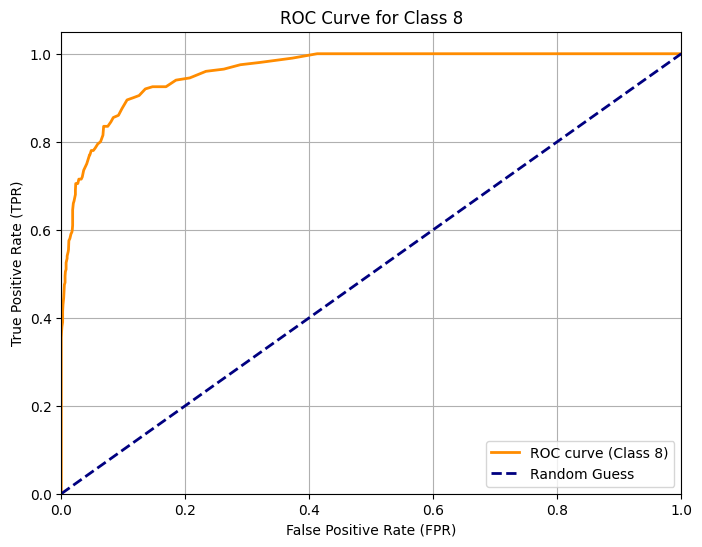

AUC for class 8: 0.9608


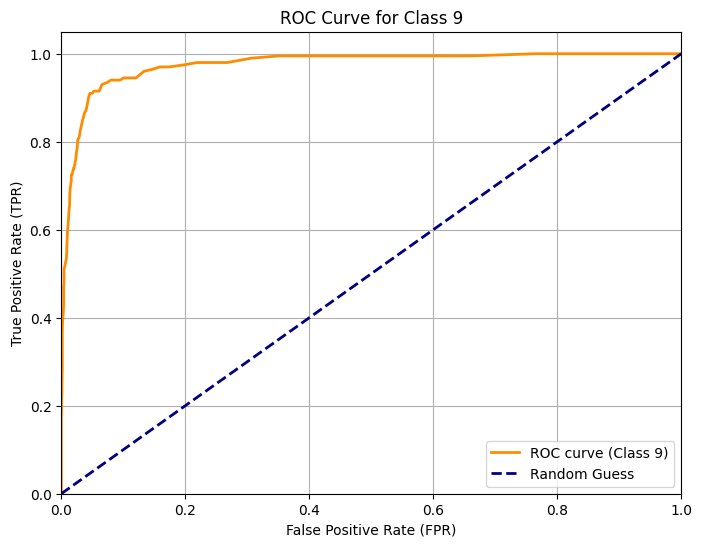

AUC for class 9: 0.9753
Average AUC Score: 0.9816


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

# Compute confusion matrix for each ovr classifier
def compute_tpr_fpr_ovr_classifier(classifier, dataloader):
    classifier.eval()
    tresholds = np.linspace(0, 1, 100)
    
    val_labels = []
    val_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            labels = (labels == class_index).int()
            val_labels.extend(labels.numpy())
            outputs = classifier(features)
            val_predictions.extend(outputs.numpy().squeeze())
        
    val_labels = np.array(val_labels)
    val_predictions = np.array(val_predictions)
    
    fpr_values = []
    tpr_values = []
    
    for treshold in tresholds:
        predictions = (val_predictions >= treshold).astype(int)
        
        TP = np.sum((predictions == 1) & (val_labels == 1))
        FP = np.sum((predictions == 1) & (val_labels == 0))
        TN = np.sum((predictions == 0) & (val_labels == 0))
        FN = np.sum((predictions == 0) & (val_labels == 1))
        
        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)
        
        fpr_values.append(fpr)
        tpr_values.append(tpr)
    
    return fpr_values, tpr_values

def plot_roc_curve(fpr, tpr, class_index):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Class {class_index})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for Class {class_index}')
    plt.legend(loc="lower right")
    plt.grid(True)  # Improve readability
    plt.show()

def compute_auc(fpr, tpr):
    # Sort values in ascending order
    sorted_pairs = sorted(zip(fpr, tpr))
    fpr_sorted, tpr_sorted = zip(*sorted_pairs)

    return np.trapz(tpr_sorted, fpr_sorted)

average_auc_score = 0

for class_index, classifier in enumerate(ovr_classifiers):
    fpr, tpr = compute_tpr_fpr_ovr_classifier(classifier, val_pca_loader)
    plot_roc_curve(fpr, tpr, class_index)
    auc = compute_auc(fpr, tpr)
    print(f"AUC for class {class_index}: {auc:.4f}")
    average_auc_score += auc

average_auc_score /= 10
print(f"Average AUC Score: {average_auc_score:.4f}")
